# Introduction to CIDs

This notebook introduces CIDs, how to specify decsions and utility nodes, and how to find optimal policies.

To open and run this notebook in your browser with Google Colab, use this link:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/causalincentives/pycid/blob/master/notebooks/CID_Basics_Tutorial.ipynb)

### Table of contents
1. [Definitions](#defs)
2. [Instantiating and Plotting a CID](#cid)
3. [Graphical Properties](#DAG)
4. [Causal Influence Models](#CIM)
5. [Solving CIMs](#Solving)

In [1]:
# importing necessary libraries
try:
    import pycid
except ModuleNotFoundError:
    import sys

    !{sys.executable} -m pip install git+https://github.com/causalincentives/pycid # for the latest development version
    import pycid

import numpy as np

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 1) Defintions <a name="defs"></a>

We begin this tutorial by defining a causal influence diagram (CID) and a causal influence model (CIM):

<div class="alert alert-block alert-info">
<b>Definition:</b> 
A <b>Causal influence Diagram (CID)</b> (Everitt et al, 2021) is a tuple $(\textbf{V}, \textbf{E})$  where:
    
   - $(\textbf{V}, \textbf{E})$ is a directed acyclic graph with a set of vertices $\textbf{V}$ connected by directed edges $\textbf{E} \subseteq \textbf{V} \times \textbf{V}$. 
 
 These vertices are partitioned into:
    
    - $\textbf{D} \subseteq \textbf{V}$ is a set of decision nodes represented by rectangles.
        
    - $\textbf{U} \subseteq \textbf{V} \setminus \textbf{D}$ is a set of utility nodes represented by diamonds and utility nodes have no successors.
        
    - $\textbf{X} = \textbf{V} \setminus (\textbf{D} \cup \textbf{U})$ is the set of chance nodes represented by ovals.
    
   
</div> 
 

<div class="alert alert-block alert-info">
<b>Definition:</b> 
A <b>Causal influence Model (CIM)</b> (Everitt et al, 2021) is a tuple $(\textbf{V}, \textbf{E}, \theta)$  where $(\textbf{V}, \textbf{E})$ is a CID and:
      
- $\theta$ is a parameterisation over the nodes in the CID specifying:
    
     - A finite domain $dom(V)$ for each node $V \in \textbf{V}$.
        
     - Real-valued domains $dom(U) \subset \mathbb{R}$ for all utility nodes $U \in \textbf{U}$.
        
     - A set of conditional probability distributions (CPDs), $\Pr(\textbf{V} \mid pa_V$), for every chance and utility node $\textbf{X} \cup \textbf{U} \in \textbf{V}$. Taken together, these form a partial distribution $\Pr(\textbf{X},\textbf{U} : \textbf{D}) = \prod_{V \in \textbf{V} \setminus \textbf{D}} \Pr(V | Pa_V)$ over the variables in the CID.
        
</div> 

# 2) Instantiating and plotting a CID <a name="cid"></a>

For many purposes, including incentive analysis in single-decision CIDs (see the incentives tutorial), we only need to know the causal relationships between variables (we need not specify a parameterisation). So, we will start by showing how to instantiate a simple CID in this codebase.

We need to specify:

- the graph's set of nodes and edges.
- the partioning of all nodes into decision, utility, and chance nodes.

Our first example is taken from Everitt et al (2019)'s "Understanding Agent Incentives using
Causal Influence Diagrams":

__Fitness Tracker Example:__ _A machine learning systemis  recommending  calorie  intake  (decision)  to  optimizethe user’s fitness (utility). The optimal calorie intake de-pends on the person’s physical activity, which cannot be measured directly. Instead, the decision must be based on a step count provided by a fitness tracker. The tracker designer developed the software behind the tracker firmware of the fitness counter's step counter._ 

- TD = Tracker designer
- TF = Tracker firmware
- SC = Step count
- EF = Estimation Formula
- EWD = Estimated Walking Distance
- P = Physical activity
- D = Dirty clothes
- C = Reccomended calorie intake (decision node)
- F = Fitness (utility node)

A cid for this example is created as an instance of our CID class. Its constructor takes the edges of the cid as its first argument, then a specification of the cid's decision and utility nodes. All other nodes which are not decision or utility nodes, but were introduced in the edge pairs, are chance nodes.

In [2]:
cid = pycid.CID(
    [
        ("TD", "TF"),  # an edge TD -> TF exists
        ("TF", "SC"),
        ("TF", "C"),
        ("EF", "EWD"),
        ("EWD", "C"),
        ("C", "F"),
        ("P", "D"),
        ("P", "SC"),
        ("P", "F"),
        ("SC", "C"),
        ("SC", "EWD"),
    ],
    decisions=["C"],
    utilities=["F"],
)

We call the CID class' method "draw" to plot this single-agent CID. Decision variables are denoted by blue rectangles, utilty nodes by yellow diamonds, and chance nodes by gray circles.

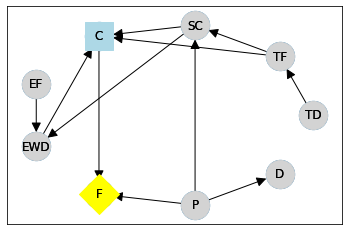

In [3]:
cid.draw()

# 4) Causal Influence Models <a name="CIM"></a>

Recall from the definitions earlier that a causal influence model is a parameterised CID.

Consider a simple 3 node cid:

In [4]:
cid = pycid.CID([("X", "D"), ("X", "U"), ("D", "U")], decisions=["D"], utilities=["U"])

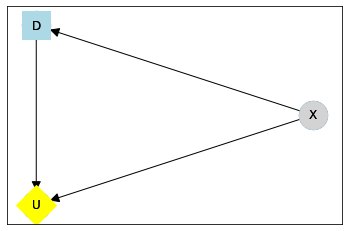

In [5]:
cid.draw()

We can parameterise it as follows. In particular, note that we don't need to specify a particular relationship for the decision D -- a list of possible values suffices.

In [6]:
cid.model.update(
    X=pycid.discrete_uniform([0, 1]),  # A uniform random CPD over its domain [0,1]
    U=lambda X, D: int(X == D),  # specifies how 'U''s CPD functionally depends on its parents ('D' and 'S').
    D=[0, 1],
)  # specifies the domain of 'D' as [0,1].

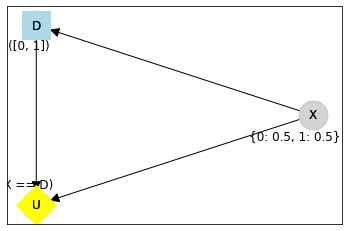

In [7]:
cid.draw()  # adds labels to the nodes in the CID to make us aware that we now have a CIM.

## 5) Solving CIMs <a name="Solving"></a>

Solving a CIM means finding an optimal policy:

In [8]:
cid.solve()

{'D': StochasticFunctionCPD<D> 
 {'X': 0}  ->  0
 {'X': 1}  ->  1}

The optimal policy for 'D' is to choose action $0$ when the value of 'X' is 0, and action $1$ when the value of 'X' is $1$.

We can determine the agent's expected utility for this optimal policy by adding it back into the model:

In [9]:
cid.model.update(**cid.solve())  # or, shorter, cid.impute_optimal_policy()
cid.expected_utility(
    context={}, intervention={}
)  # The argument in an empty dictionary because we do not need to specify a context.

1.0

Now let's turn to the case where the CID has more than one decision node. 

In [10]:
cid = pycid.CID(
    [("X1", "X2"), ("X1", "D1"), ("D1", "X2"), ("X2", "U"), ("X2", "D2"), ("D2", "U")],
    decisions=["D1", "D2"],  # two decision nodes 'D1' and 'D2'
    utilities=["U"],
)

# adding a parametirsation:
cid.model.update(
    X1=pycid.discrete_uniform([0, 1]),
    D1=[0, 1],
    D2=[0, 1],
    X2=lambda X1, D1: int(X1 == D1),
    U=lambda X2, D2: int(X2 == D2),
)

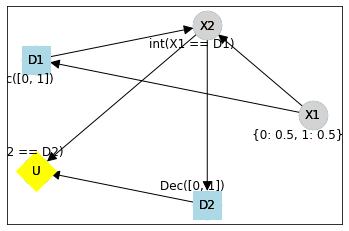

In [11]:
cid.draw()

In order to compute a subgame perfect policy, the CID must have sufficient recall (see the definition based on strategic relevance in the MACID tutorial) - 
Does the optimal deicion rule for 'D2' depend on the optimal decision rule for "D1" and vice versa? If only one decision relies on the other, then we can solve the cid using backwards induction and the CID has sufficent recall. However, if both decisions depend on one another, then the CID has insufficient recall. 

Note: Insufficient recall in the context of CIDs means that the agent forgets the decision choices they chose previously (hence the name), and so is rare. A generalised condition for when we can and cannot perform backwards induction becomes more important in the context of multi-agent CIDs when multiple agents might have to make decisions simultaneously (eg a prisoner's dilemma).

In [12]:
print(cid.sufficient_recall())

True


In [13]:
solution = cid.solve()
print(solution["D2"])

StochasticFunctionCPD<D2> 
{'X2': 0}  ->  0
{'X2': 1}  ->  1


In [14]:
print(solution["D1"])

StochasticFunctionCPD<D1> 
{'X1': 0}  ->  0
{'X1': 1}  ->  0


So, as expected from the setup, an optimal policy is to pick $0/1$ at $D2$ if 'S2' = 0/1 (it should match what the value of 'S2' is) and to always select $0$ at $D1$.

We can again find the expected utility for this policy:

In [15]:
cid.model.update(**solution)
cid.expected_utility({})

1.0